In [1]:
import os
import pandas as pd
import numpy as np
import warnings

## 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 전처리 및 변환
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

## 모델 학습 및 평가 도구
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline

## 분류 모델
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## 모델 평가 지표
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
## 통계 모델링
import statsmodels.api as sm

## Kaggle
import kagglehub


warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=FutureWarning, module='numpy')


path = kagglehub.dataset_download("mysarahmadbhat/lung-cancer")
files = os.listdir(path)
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        data = pd.read_csv(file_path)

c:\Users\badro97\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [4]:
data.shape

(309, 16)

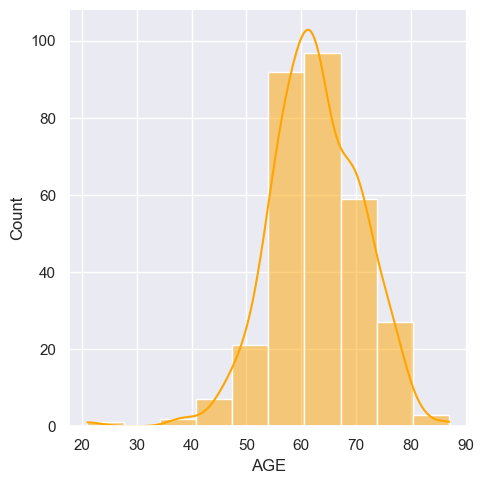

In [5]:
# 나이 분포
sns.set(rc={"figure.figsize":(6,4)})
sns.displot(data["AGE"], kde=True, color="orange", bins=10)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_23284\2494604751.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "GENDER", data=data, palette="mako")


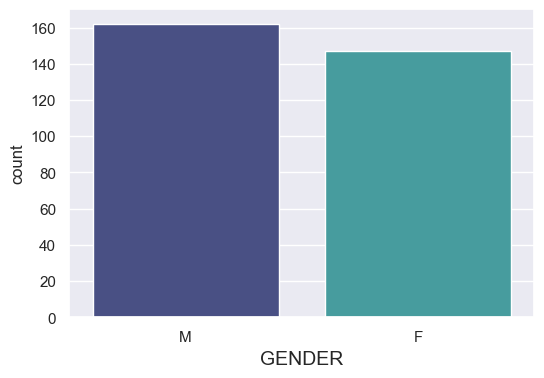

In [6]:
# 성별 분포
plt.figure(figsize=(6,4))
sns.countplot(x = "GENDER", data=data, palette="mako")
plt.xlabel("GENDER", fontsize=14)
plt.show()

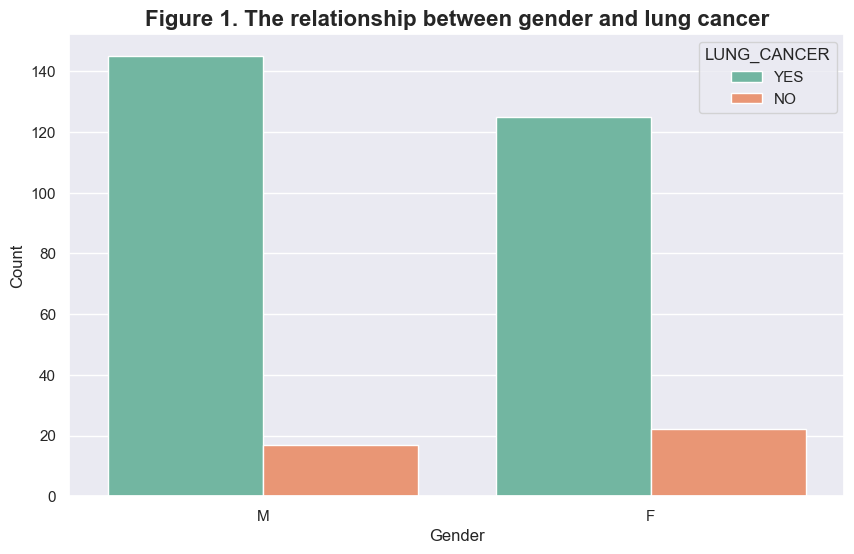

<Figure size 1000x600 with 0 Axes>

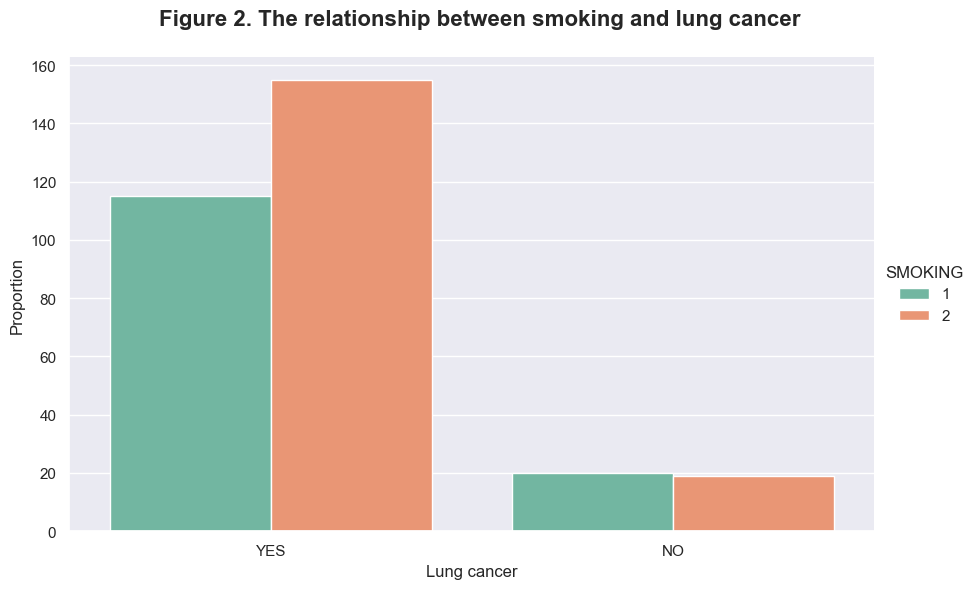

In [7]:
# Figure 1
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='GENDER', hue='LUNG_CANCER', palette='Set2')
plt.title('Figure 1. The relationship between gender and lung cancer', fontsize=16, weight='bold')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Figure 2
plt.figure(figsize=(10, 6))
sns.catplot(
    data=data, 
    x='LUNG_CANCER', 
    hue='SMOKING', 
    kind='count', 
    height=6, 
    aspect=1.5, 
    palette='Set2'
)
plt.subplots_adjust(top=0.9)
plt.suptitle('Figure 2. The relationship between smoking and lung cancer', fontsize=16, weight='bold')
plt.xlabel('Lung cancer')
plt.ylabel('Proportion')
plt.show()


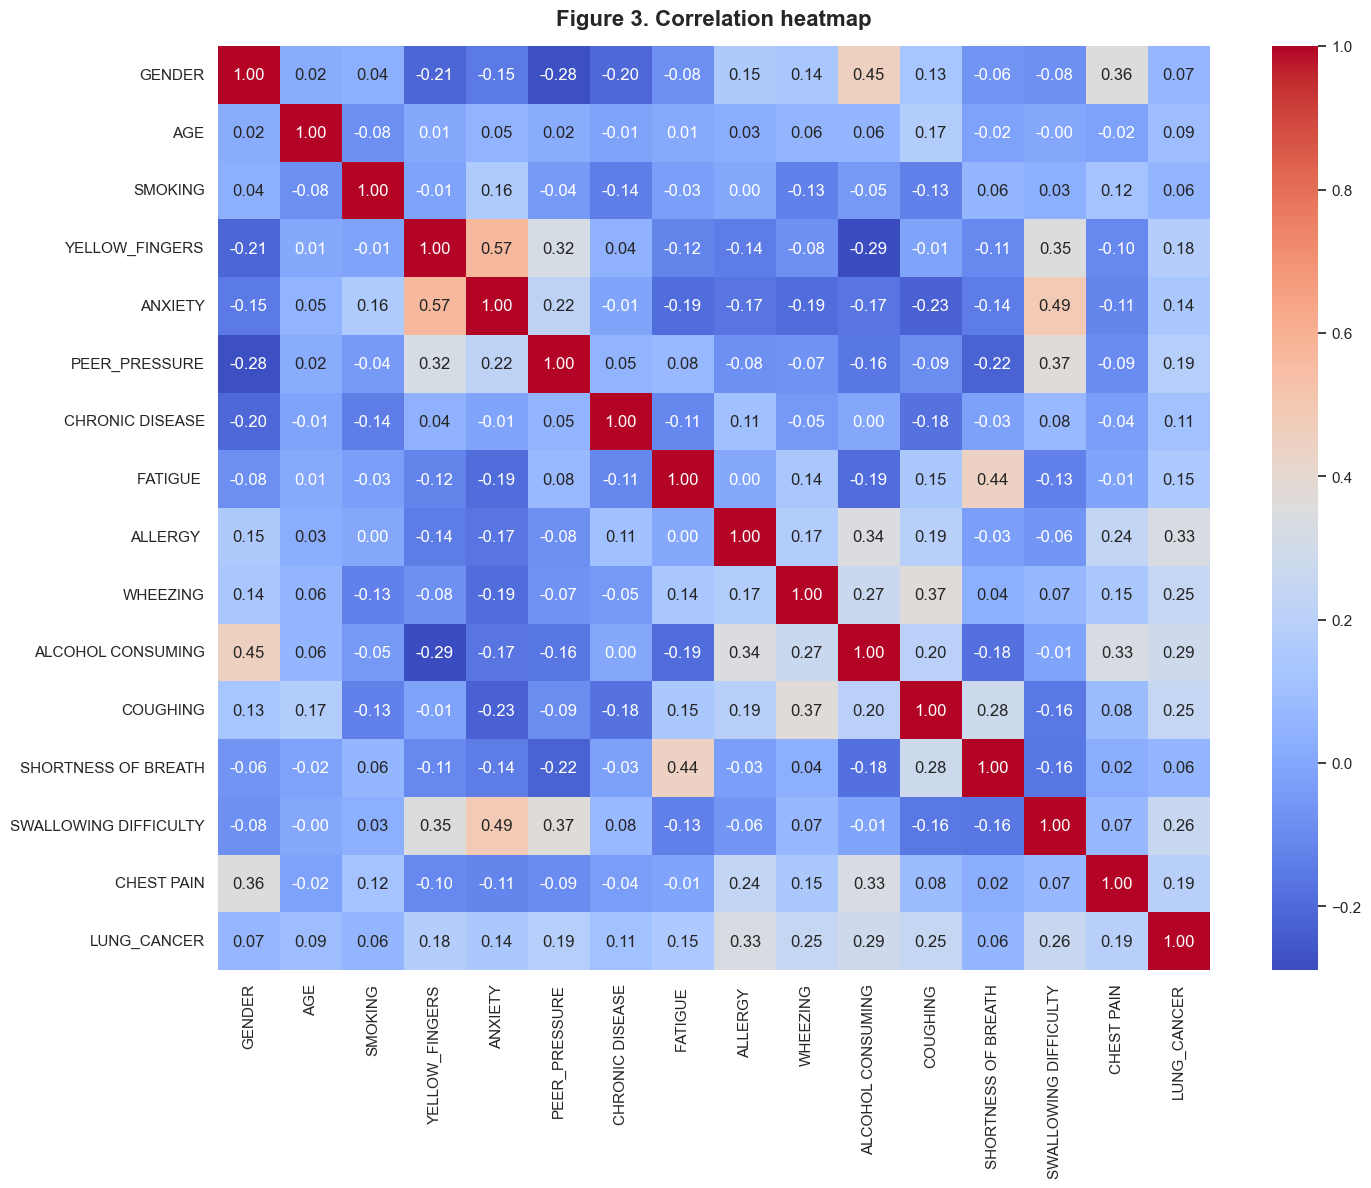

상관계수 높은 변수 쌍:
GENDER               YELLOW_FINGERS        -0.212959
YELLOW_FINGERS       GENDER                -0.212959
PEER_PRESSURE        SHORTNESS OF BREATH   -0.220175
SHORTNESS OF BREATH  PEER_PRESSURE         -0.220175
ANXIETY              COUGHING              -0.225644
COUGHING             ANXIETY               -0.225644
GENDER               PEER_PRESSURE         -0.275564
PEER_PRESSURE        GENDER                -0.275564
YELLOW_FINGERS       ALCOHOL CONSUMING     -0.289025
ALCOHOL CONSUMING    YELLOW_FINGERS        -0.289025
dtype: float64


In [8]:
label_encoder = LabelEncoder()
data['LUNG_CANCER'] = label_encoder.fit_transform(data['LUNG_CANCER'])
data['GENDER'] = label_encoder.fit_transform(data['GENDER'])

numeric_data = data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Figure 3. Correlation heatmap', fontsize=16, weight='bold', pad=15)
plt.show()


# 다중공선성이 의심되는 변수 확인
high_corr_pairs = corr.unstack().sort_values(kind="quicksort", ascending=False)
print("상관계수 높은 변수 쌍:")
print(high_corr_pairs[high_corr_pairs < 1].tail(10))  # 상위 상관 변수 확인

다중공선성...

In [9]:
X = data.drop('LUNG_CANCER', axis=1)
y = data['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1935)

#표준화 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 학습 데이터로 스케일링 학습
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  

print("PCA 적용된 학습 데이터 Shape:", X_train_pca.shape)
print("PCA 적용된 테스트 데이터 Shape:", X_test_pca.shape)

PCA 적용된 학습 데이터 Shape: (247, 15)
PCA 적용된 테스트 데이터 Shape: (62, 15)


In [10]:
# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

Explained Variance Ratios: [0.18829563 0.1377818  0.10391818 0.0903405  0.07342243 0.06507746
 0.05942504 0.0516539  0.05002928 0.04108674 0.03947431 0.03275092
 0.02834999 0.02132515 0.01706868]


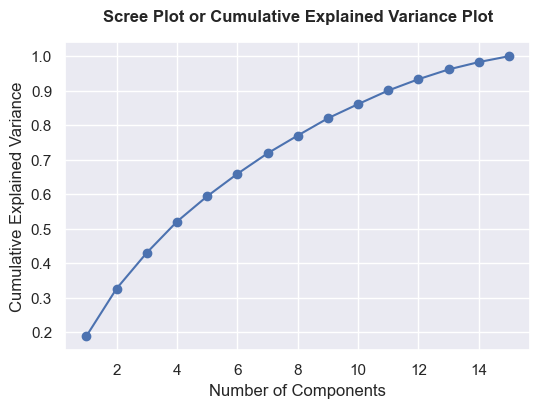

In [11]:
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot or Cumulative Explained Variance Plot', weight='bold', pad=15)
plt.grid(True)
plt.show()

In [12]:
# PCA를 활용한 데이터 차원 축소 과정
desired_variance = 0.95  # 95% 분산 유지
num_components = np.argmax(cumulative_variance >= desired_variance) + 1
print(f"\nNumber of components selected for {desired_variance * 100}% variance: {num_components}")


Number of components selected for 95.0% variance: 13


In [13]:
# 선택한 주성분 개수로 PCA 재적용
pca = PCA(n_components=num_components)
X_train_pca_selected = pca.fit_transform(X_train_scaled)
X_test_pca_selected = pca.transform(X_test_scaled)

In [14]:
print(f"\nFinal shape of training data: {X_train_pca_selected.shape}")
print(f"Final shape of testing data: {X_test_pca_selected.shape}")


Final shape of training data: (247, 13)
Final shape of testing data: (62, 13)


### Logit

In [15]:
# 상수열 추가 (절편을 위한)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Logit 모델 학습
logit_model = sm.Logit(y_train, X_train_const).fit()

# 테스트 데이터 예측
logit_preds_prob = logit_model.predict(X_test_const)
logit_preds = (logit_preds_prob > 0.5).astype(int)

# 모델 평가
logit_auc = roc_auc_score(y_test, logit_preds_prob)
logit_confusion = confusion_matrix(y_test, logit_preds)
logit_class_report = classification_report(y_test, logit_preds)

print("Logit AUC:", logit_auc)
print("Confusion Matrix:\n", logit_confusion)
print("Classification Report:\n", logit_class_report)


Optimization terminated successfully.
         Current function value: 0.129461
         Iterations 10
Logit AUC: 0.8736842105263158
Confusion Matrix:
 [[ 2  3]
 [ 2 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.95      0.96      0.96        57

    accuracy                           0.92        62
   macro avg       0.72      0.68      0.70        62
weighted avg       0.91      0.92      0.92        62



In [16]:
# Logit 모델 요약
logit_summary = logit_model.summary2().tables[1]

logit_df = pd.DataFrame({
    "coef": logit_summary["Coef."],
    "std error": logit_summary["Std.Err."],
    "p-value": logit_summary["P>|z|"],
    "2.5%": logit_summary["[0.025"],
    "97.5%": logit_summary["0.975]"]
})
logit_df

,coef,std error,p-value,2.5%,97.5%
const,-39.142462,7.587576,2.485948e-07,-54.013838,-24.271086
GENDER,-0.680306,0.888085,4.436543e-01,-2.420920,1.060308
AGE,0.049092,0.037656,1.923389e-01,-0.024713,0.122897
SMOKING,3.023272,0.968083,1.790508e-03,1.125863,4.920681
YELLOW_FINGERS,1.326362,0.932750,1.550291e-01,-0.501795,3.154519
ANXIETY,0.928038,0.960909,3.341485e-01,-0.955309,2.811385
PEER_PRESSURE,2.472571,0.881734,5.043941e-03,0.744404,4.200737
CHRONIC DISEASE,3.885044,1.129900,5.851729e-04,1.670480,6.099608
FATIGUE,3.742456,1.032015,2.874466e-04,1.719744,5.765168
ALLERGY,1.554282,0.906777,8.651534e-02,-0.222968,3.331532


In [17]:
# Logit 모델 AIC, BIC
logit_aic = logit_model.aic
logit_bic = logit_model.bic
print("Logit AIC:", logit_aic)
print("Logit BIC:", logit_bic)

Logit AIC: 95.95355095237996
Logit BIC: 152.1037643384276


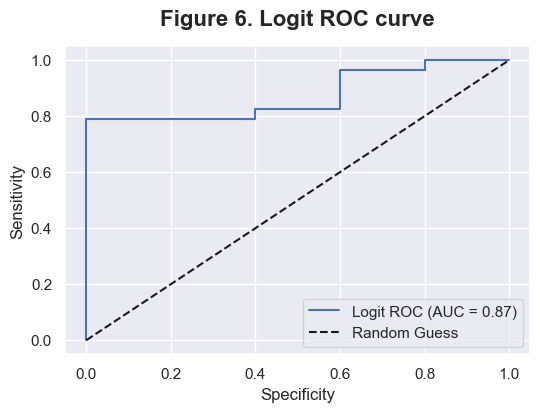

In [18]:
# Logit ROC 곡선
logit_fpr, logit_tpr, _ = roc_curve(y_test, logit_preds_prob)
logit_roc_auc = auc(logit_fpr, logit_tpr)

plt.figure()
plt.plot(logit_fpr, logit_tpr, label=f'Logit ROC (AUC = {logit_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Figure 6. Logit ROC curve', fontsize=16 ,weight='bold', pad=15)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.show()

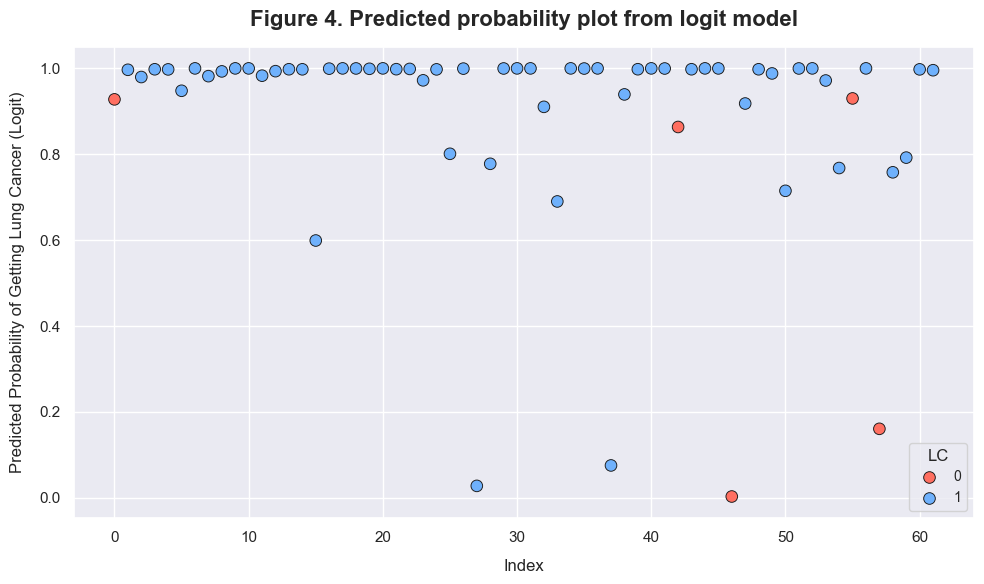

In [19]:
# 예측 확률 및 실제값 정리
data_logit = pd.DataFrame({
    'Index': range(len(logit_preds_prob)),
    'Predicted Probability': logit_preds_prob,
    'LC': y_test
})

# Logit 모델 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_logit,
    x='Index',
    y='Predicted Probability',
    hue='LC',
    palette={0: '#FF6F61', 1: '#6FB1FC'},
    edgecolor='k',
    s=70 
)
plt.title('Figure 4. Predicted probability plot from logit model', fontsize=16, weight='bold', pad=15)
plt.xlabel('Index', fontsize=12, labelpad=10)
plt.ylabel('Predicted Probability of Getting Lung Cancer (Logit)', fontsize=12, labelpad=10)
plt.legend(title='LC', loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

### Probit

In [20]:
# Probit 모델 학습
probit_model = sm.Probit(y_train, X_train_const).fit()

# 테스트 데이터 예측
probit_preds_prob = probit_model.predict(X_test_const)
probit_preds = (probit_preds_prob > 0.5).astype(int)

# 모델 평가
probit_auc = roc_auc_score(y_test, probit_preds_prob)
probit_confusion = confusion_matrix(y_test, probit_preds)
probit_class_report = classification_report(y_test, probit_preds)

print("Probit AUC:", probit_auc)
print("Confusion Matrix:\n", probit_confusion)
print("Classification Report:\n", probit_class_report)


Optimization terminated successfully.
         Current function value: 0.128581
         Iterations 9
Probit AUC: 0.8842105263157894
Confusion Matrix:
 [[ 2  3]
 [ 2 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.95      0.96      0.96        57

    accuracy                           0.92        62
   macro avg       0.72      0.68      0.70        62
weighted avg       0.91      0.92      0.92        62



In [21]:
# Probit 모델 요약
probit_summary = probit_model.summary2().tables[1]

probit_df = pd.DataFrame({
    "coef": probit_summary["Coef."],
    "std error": probit_summary["Std.Err."],
    "p-value": probit_summary["P>|z|"],
    "2.5%": probit_summary["[0.025"],
    "97.5%": probit_summary["0.975]"]
})
probit_df

,coef,std error,p-value,2.5%,97.5%
const,-21.603868,3.909408,3.273854e-08,-29.266168,-13.941569
GENDER,-0.344718,0.480142,4.727874e-01,-1.285779,0.596342
AGE,0.024344,0.021208,2.510321e-01,-0.017223,0.065910
SMOKING,1.697225,0.513402,9.469139e-04,0.690976,2.703473
YELLOW_FINGERS,0.809913,0.527554,1.247296e-01,-0.224075,1.843900
ANXIETY,0.480480,0.531553,3.660393e-01,-0.561345,1.522305
PEER_PRESSURE,1.378971,0.469342,3.302383e-03,0.459077,2.298864
CHRONIC DISEASE,2.128202,0.605698,4.420229e-04,0.941055,3.315348
FATIGUE,2.157850,0.553220,9.598373e-05,1.073558,3.242142
ALLERGY,0.869003,0.488857,7.546598e-02,-0.089139,1.827145


In [22]:
# Probit 모델 AIC, BIC
probit_aic = probit_model.aic
probit_bic = probit_model.bic
print("Probit AIC:", probit_aic)
print("Probit BIC:", probit_bic)

Probit AIC: 95.51902000432204
Probit BIC: 151.6692333903697


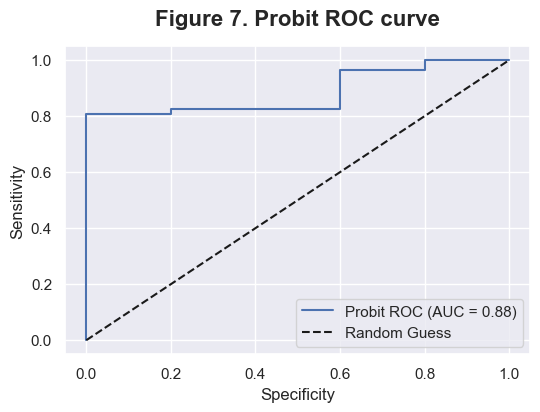

In [23]:
# Probit ROC 곡선
probit_fpr, probit_tpr, _ = roc_curve(y_test, probit_preds_prob)
probit_roc_auc = auc(probit_fpr, probit_tpr)

# Probit ROC 곡선
plt.figure()
plt.plot(probit_fpr, probit_tpr, label=f'Probit ROC (AUC = {probit_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Figure 7. Probit ROC curve', fontsize=16 ,weight='bold', pad=15)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')
plt.show()

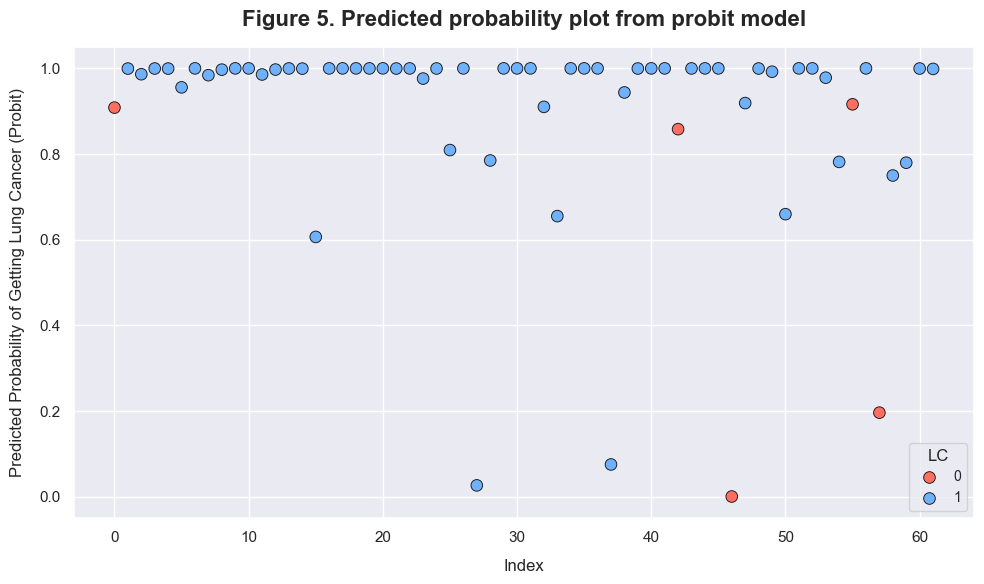

In [24]:
# 예측 확률 및 실제값 정리
data_probit = pd.DataFrame({
    'Index': range(len(probit_preds_prob)),
    'Predicted Probability': probit_preds_prob,
    'LC': y_test
})

# Probit 모델 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_probit,
    x='Index',
    y='Predicted Probability',
    hue='LC',
    palette={0: '#FF6F61', 1: '#6FB1FC'}, 
    edgecolor='k',
    s=70 
)
plt.title('Figure 5. Predicted probability plot from probit model', fontsize=16, weight='bold', pad=15)
plt.xlabel('Index', fontsize=12, labelpad=10)
plt.ylabel('Predicted Probability of Getting Lung Cancer (Probit)', fontsize=12, labelpad=10)
plt.legend(title='LC', loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

## ML

### Decision Tree

In [25]:
def decision_tree(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(), 
        DecisionTreeClassifier(random_state=42, criterion='entropy')
    )
    params = {
        "decisiontreeclassifier__max_depth" : [3,4,5,6,7], # 트리의 최대 깊이
        "decisiontreeclassifier__min_samples_split" :[2,3] # 분할을 위한 최소 샘플 수
    }
    clf = RandomizedSearchCV(
        pipe, 
        param_distributions=params, 
        n_iter=10,  # 랜덤 탐색 횟수
        cv=5, # 폴드 수
        scoring='accuracy', # 평가 지표
        n_jobs=-1, # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model


In [26]:
dt = decision_tree(X_train, y_train)
print(dt)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42))])


### RandomForest

In [27]:
def random_forest_small_data(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        RandomForestClassifier(random_state=42)
    )
    params = {
        "randomforestclassifier__n_estimators": [10, 50],
        "randomforestclassifier__max_depth": [3, 5, 10], # 트리의 최대 깊이
        "randomforestclassifier__min_samples_split": [2, 3], # 분할을 위한 최소 샘플 수
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=5,  # 랜덤 탐색 횟수
        cv=3,  # 폴드 수
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [28]:
rf = random_forest_small_data(X_train, y_train)
print(rf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=3,
                                        n_estimators=10, random_state=42))])


### Support Vector

In [29]:
def support_vector(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        SVC(random_state=42)
    )
    params = {
        "svc__C": [0.1, 1, 10],  # 정규화 파라미터
        "svc__kernel": ['linear', 'rbf'],  # 커널 종류
        "svc__gamma": ['scale', 'auto']  # 감마 값
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=3,  # 탐색 횟수를 줄임
        cv=3,  # 3-폴드 교차 검증
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [30]:
svc = support_vector(X_train, y_train)
print(svc)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=10, gamma='auto', kernel='linear', random_state=42))])


### K-Nearest Neighbors

In [31]:
def kneighbors(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        KNeighborsClassifier()
    )
    params = {
        "kneighborsclassifier__n_neighbors": [3, 5, 7],  # 이웃의 수
        "kneighborsclassifier__weights": ['uniform', 'distance'],  # 가중치 방식
        "kneighborsclassifier__metric": ['euclidean', 'manhattan']  # 거리 측정 방법
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=3,  # 탐색 횟수를 줄임
        cv=3,  # 3-폴드 교차 검증
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [32]:
knn = kneighbors(X_train, y_train)
print(knn)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])


### Gradient Boosting

In [33]:
def gradient_boosting(X_train, y_train):
    pipe = make_pipeline(
        SimpleImputer(),
        StandardScaler(),
        GradientBoostingClassifier(random_state=42)
    )
    params = {
        "gradientboostingclassifier__n_estimators": [50, 100],  # 트리 개수
        "gradientboostingclassifier__learning_rate": [0.01, 0.1],  # 학습률
        "gradientboostingclassifier__max_depth": [3, 5],  # 트리의 최대 깊이
        "gradientboostingclassifier__min_samples_split": [2, 5],  # 분할을 위한 최소 샘플 수
        "gradientboostingclassifier__min_samples_leaf": [1, 2],  # 리프 노드의 최소 샘플 수
    }
    clf = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=3,  # 탐색 횟수를 줄임
        cv=3,  # 3-폴드 교차 검증
        scoring='accuracy',  # 평가 지표
        n_jobs=-1,  # 병렬 처리
        random_state=42  # 랜덤 상태 고정
    )
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    return model

In [34]:
gdb = gradient_boosting(X_train, y_train)
print(gdb)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5, min_samples_leaf=2,
                                            random_state=42))])


### 모델 테스트 비교

In [35]:
def model_pred_results(models, X_test, y_test):
    # 결과 저장 리스트
    results = []
    for name, model in models.items():
        # 모델 예측
        pred = model.predict(X_test)
        # 성능 지표 계산
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted')
        f1 = f1_score(y_test, pred, average='weighted')
        
        results.append({
            "모델": name,
            "정확도": accuracy,
            "정밀도": precision,
            "재현율": recall,
            "F1 Score": f1
        })
    results_df = pd.DataFrame(results)
    return results_df

In [36]:
models = {
    "Decision Tree": dt,
    "Random Forest": rf,
    "Support Vector": svc,
    "K-Nearest Neighbors": knn,
    "Gradient Boosting": gdb
}

results = model_pred_results(models, X_test, y_test)
results

,모델,정확도,정밀도,재현율,F1 Score
0,Decision Tree,0.903226,0.920486,0.903226,0.910426
1,Random Forest,0.935484,0.926371,0.935484,0.927976
2,Support Vector,0.919355,0.912125,0.919355,0.915225
3,K-Nearest Neighbors,0.887097,0.896985,0.887097,0.891729
4,Gradient Boosting,0.870968,0.892250,0.870968,0.880568


### BEST : Random Forest

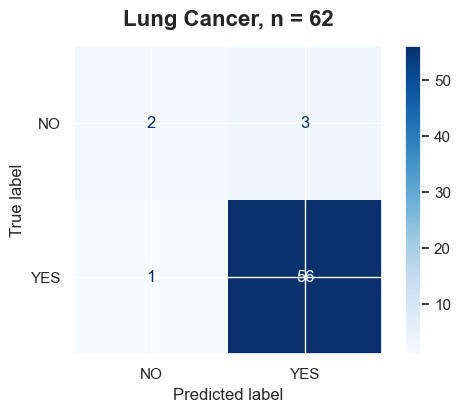

In [37]:
y_pred = rf.predict(X_test)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)
# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Lung Cancer, n = {len(y_test)}', fontsize=16 ,weight='bold', pad=15)
plt.show()


#### 결론 - 데이터 변경 고려 (크기 및 Skew)